In [1]:
import healpy as hp
import numpy as np
import math
import matplotlib as mpl
import matplotlib.image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
%matplotlib inline
from matplotlib import colors
import astropy.io
from astropy.io import fits
from astropy import units as u
from astropy.units import cds
from astropy import constants as const
import random
import scipy
import scipy.integrate as integrate
from scipy import stats

In [2]:
def I(A1, A2, nu_p1, nu_sd, f, nu):
    ''' Calculate a specific intensity curve for a pixel at either a range or a specific value of nu. First three args
        should be either all floats or all arrays; if arrays, nu should be float, otherwise nu can be either.
        
        Input:  A1: float or array, amplitude from primary map
                A2: float or array, amplitude from secondary map
                nu_p1: float or array, peak frequency from primary map
                nu_sd: array, template frequency
                f: array, template frequency 
                nu: float or array, range of frequencies over which to evaluate the function
        
        Return: array of shape [1,n] (if first three args are floats); 
                  --> values of specific intensity in MJy/sr for each of the n discrete values of nu
                array of shape [n,1] (if first three args are arrays);
                  --> values of specific intensity in MJy/sr at a given nu for each pixel of a map
    '''
    nu_p0 = 30. 
    nu_p2 = 33.35                                                 #sets frequency peak for all secondary pixels
    nu_01 = 22.8                                                  #sets reference freq for primary pixels
    nu_02 = 41.0                                                  #sets reference freq for secondary pixels
    nu_1 = nu_01*(nu_p0/nu_p1)                                    #sets the value nu1 for f_sd1
    nu_2 = nu_02*(nu_p0/nu_p2)                                    #same for 2
    nu_fsd1 = nu*(nu_p0/nu_p1)
    nu_fsd2 = nu*(nu_p0/nu_p2)
    
    f_sd1 = np.interp(nu_1, nu_sd, f)                             #interpolates nu_sd and f to create f_sd1 at nu1
    f_sd2 = np.interp(nu_2, nu_sd, f)                             #same for 2
    f_nu1 = np.interp(nu_fsd1, nu_sd, f)                          #same for general nu
    f_nu2 = np.interp(nu_fsd2, nu_sd, f)                          #same for general nu
    
    I_1 = A1*((nu_01/nu)**2)*(f_nu1/f_sd1)                         #component from primary 
    I_2 = A2*((nu_02/nu)**2)*(f_nu2/f_sd2)                         #component from secondary
    m_K1 = I_1*u.K*(2*(nu*u.GHz)**2*const.k_B)/(const.c**2*cds.sr) #adds units to primary
    m_K2 = I_2*u.K*(2*(nu*u.GHz)**2*const.k_B)/(const.c**2*cds.sr) #same for secondary
    m_J1 = m_K1.to(cds.MJy/cds.sr)
    m_J2 = m_K2.to(cds.MJy/cds.sr)
    m_J = m_J1 + m_J2
    return m_J * cds.sr/cds.MJy                                    #gets rid of units for plotting purposes

In [3]:
def I_therm(A_d, B_d, T_d, nu):
    
    gamma = const.h/(const.k_B*T_d)
    gam = gamma.value
    frac1 = nu/(545)
    frac2 = (np.exp(gam*545)-1)/(np.exp(gam*nu)-1)
    Beta = B_d + 1
    
    S_td = A_d*(frac1**Beta)*frac2
    I_td = S_td*u.K*(2*(nu*u.GHz)**2*const.k_B)/(const.c**2*cds.sr)
    I_thermdust = I_td.to(cds.MJy/cds.sr)
    
    return I_thermdust * cds.sr/cds.MJy

In [4]:
def change_coord(m, coord):
    """ Change coordinates of a HEALPIX map

    Parameters
    ----------
    m : map or array of maps
      map(s) to be rotated
    coord : sequence of two character
      First character is the coordinate system of m, second character
      is the coordinate system of the output map. As in HEALPIX, allowed
      coordinate systems are 'G' (galactic), 'E' (ecliptic) or 'C' (equatorial)

    Example
    -------
    The following rotate m from galactic to equatorial coordinates.
    Notice that m can contain both temperature and polarization.
    >>>> change_coord(m, ['G', 'C'])
    """
    # Basic HEALPix parameters
    npix = m.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))

    # Select the coordinate transformation
    rot = hp.Rotator(coord=reversed(coord))

    # Convert the coordinates
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)

    return m[..., new_pix]

In [5]:
#imports all the important maps that we'll use throughout the notebook

a1 = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=1, hdu=1)    #reads mean amplitude primary map
nup1 = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=4, hdu=1)  #reads mean peak freqeuncy primary map
a2 = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=1, hdu=2)    #same secondary map
Ad = hp.read_map('COM_CompMap_dust-commander_0256_R2.00 (2).fits', field=0)
Td = hp.read_map('COM_CompMap_dust-commander_0256_R2.00 (2).fits', field=1)
Bd = hp.read_map('COM_CompMap_dust-commander_0256_R2.00 (2).fits', field=2)
hdu = fits.open("COM_CompMap_AME-commander_0256_R2.00.fits")                    #opens map header for frequency template
data = hdu[3].data                                                              #takes array from hdu[3]
nu_sd = np.array([i[0] for i in data])                                          #creates an array of template frequency
f = np.array([i[1] for i in data])                                              #creates an array of spdust2 spectrum
h = hp.read_map('mom0_-90_90_1024.hpx.fits')                                    #reads map of HI column denisty
N_HI = hp.pixelfunc.ud_grade(h, 256)                                            #degrades to NPIX = 256
CNM = hp.read_map('fcnm_hi4pi_hpx.fits')                                        #reads map of CNM fraction
f_CNM = change_coord(CNM, 'CG') 
fCNM = hp.ud_grade(f_CNM, 256)                                                  #degrades to NPIX = 256

/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


In [6]:
font = {'family' : 'serif',
        'weight' : 'regular',
        'size'   : 12}
plt.rc('font', **font)
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

In [7]:
idx = np.where((np.isfinite(fCNM)) & (fCNM > 0.02))
mask = np.zeros_like(fCNM)
mask[idx] = 1

a1[mask == 0] = 0
a2[mask == 0] = 0
nup1[mask == 0] = 0
fCNM[mask == 0] = 0
N_HI[mask == 0] = 0
Ad[mask == 0] = 0
Td[mask == 0] = 0
Bd[mask == 0] = 0

a1_shortened = a1[idx]
fraction_sky = len(a1_shortened)/len(a1)
print(fraction_sky*100)

20.995457967122398


/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/home/mdodici/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:1121: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:1122: Ru

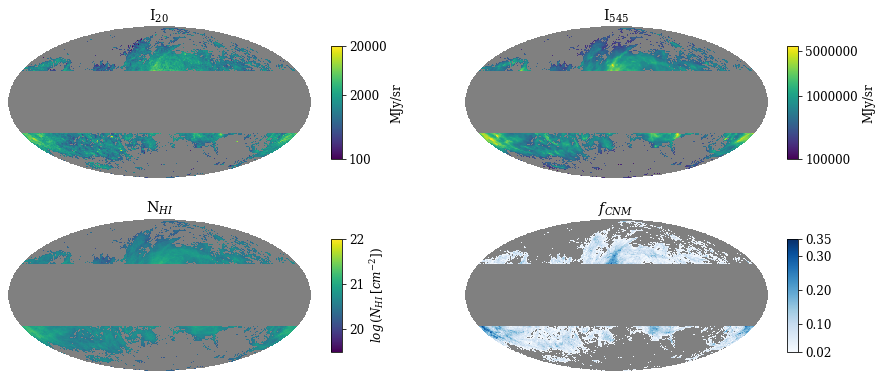

In [8]:
I20 = I(a1, a2, nup1, nu_sd, f, 20)
I30 = I(a1, a2, nup1, nu_sd, f, 30)
I_thermal = I_therm(Ad,Bd,Td,545)

mapNHI = np.log10(N_HI)
mapNHI[mask == 0] = float('NaN')
mapfCNM = fCNM
mapfCNM[mask == 0] = float('NaN')

maps, (mapx1, mapx2) = plt.subplots(2,2, figsize=(15,6.5))

plt.axes(mapx1[0])
AMEmap = hp.mollview(I20, title=r'$\mathrm{I}_{20}$', hold=True, cbar=None, min=100, max=20000, norm='log')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cmap = fig.colorbar(image, ax=ax, shrink=.7, aspect=10, ticks=[100,2000,20000], label='MJy/sr')
plt.axes(mapx1[1])
Thermmap = hp.mollview(I_thermal, title=r'$\mathrm{I}_{545}$', hold=True, cbar=None, min=1e5, max=6e6, norm='log')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cmap = fig.colorbar(image, ax=ax, shrink=.7, aspect=10, ticks=[1e5,1e6,5e6], label='MJy/sr')
plt.axes(mapx2[0])
HImap = hp.mollview(mapNHI, title=r'$\mathrm{N}_{HI}$', hold=True, cbar=None, min=19.5, max=22, badcolor='gray')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cmap = fig.colorbar(image, ax=ax, shrink=.7, aspect=10, ticks=[20,21,22], label=r'$log\,(N_{HI} \: [cm^{-2}])$')
plt.axes(mapx2[1])
fCNMmap = hp.mollview(fCNM, title=r'$f_{CNM}$', cmap='Blues',hold=True, cbar=None, min=0.02, max=0.35, badcolor='gray')
fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cmap = fig.colorbar(image, ax=ax, shrink=.7, aspect=10, ticks=[.02,.10,.20,.30,.35])

#maps.savefig('maps_used.png', dpi=300)

In [9]:
N_CNM = N_HI * fCNM

def IFN_bins(lo, hi):
    Ibin = I30[(fCNM > lo) & (fCNM <= hi)]
    Fbin = fCNM[(fCNM > lo) & (fCNM <= hi)]
    NHbin = N_HI[(fCNM > lo) & (fCNM <= hi)]
    NCbin = N_CNM[(fCNM > lo) & (fCNM <= hi)]
    nupbin = nup1[(fCNM > lo) & (fCNM <= hi)]
    return Ibin, Fbin, NHbin, NCbin, nupbin

I_bin0, F_bin0, NH_bin0, NCNM_bin0, nup_bin0 = IFN_bins(0.02, 0.05)
I_bin1, F_bin1, NH_bin1, NCNM_bin1, nup_bin1 = IFN_bins(0.05, 0.10)
I_bin2, F_bin2, NH_bin2, NCNM_bin2, nup_bin2 = IFN_bins(0.10, 0.15)
I_bin3, F_bin3, NH_bin3, NCNM_bin3, nup_bin3 = IFN_bins(0.15, 0.20)

/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less_equal
  after removing the cwd from sys.path.
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less_equal
  """
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encoun

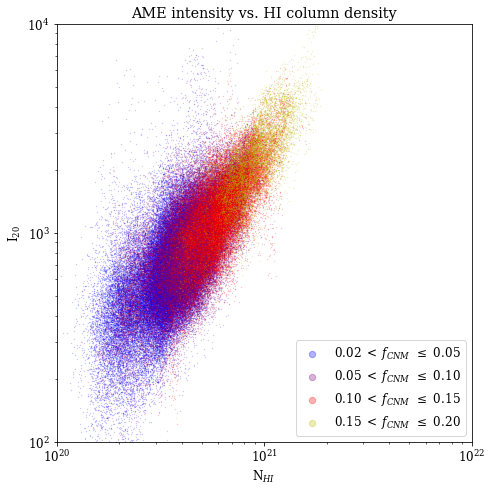

In [10]:
fig0, ax0 = plt.subplots(figsize=(7,7))

IvN0 = ax0.scatter(NH_bin0, I_bin0, s=.1, alpha=.3, c='blue')
IvN1 = ax0.scatter(NH_bin1, I_bin1, s=.1, alpha=.3, c='purple')
IvN2 = ax0.scatter(NH_bin2, I_bin2, s=.1, alpha=.3, c='red')
IvN3 = ax0.scatter(NH_bin3, I_bin3, s=.1, alpha=.3, c='y')
ax0.set_xlim(1e20, 1e22)
ax0.set_ylim(100, 1e4)
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlabel(r'$\mathrm{N}_{HI}$')
ax0.set_ylabel(r'$\mathrm{I}_{20}$')
ax0.set_title('AME intensity vs. HI column density')

labelI0 = f"0.02 " + r'$<\:f_{CNM}\;\:\leq$' + f" 0.05"
labelI1 = f"0.05 " + r'$<\:f_{CNM}\;\:\leq$' + f" 0.10"
labelI2 = f"0.10 " + r'$<\:f_{CNM}\;\:\leq$' + f" 0.15"
labelI3 = f"0.15 " + r'$<\:f_{CNM}\;\:\leq$' + f" 0.20"

ax0.legend(handles=[IvN0, IvN1, IvN2, IvN3], labels=[labelI0, labelI1, labelI2, labelI3], 
              loc='lower right', markerscale=20)

fig0.tight_layout()
#fig0.savefig('NH_I20.png', dpi=300)

In [11]:
def plot_binstd(frequencies, med, posstd, negstd, col, axnum):
    ''' Plots a median line and standard deviation region
       
        Input:
          frequencies: array or float; range of nu to be plotted
          med: array; median values at each nu
          pos: array; values at each nu of median + one standard deviation
          neg: array; values at each nu of median - one standard deviation
          col: list; color with which to plot the bin
          
        Returns: plot
    '''
    axnum.plot(frequencies, med, color=col)
    axnum.fill_between(frequencies, posstd, negstd, color=col, alpha=.7)
    return

def plot_binper(frequencies, med, per84, per16, col, axnum):
    median_line, = axnum.plot(frequencies, med, color=col)
    #axnum.fill_between(frequencies, per84, per16, color=col, alpha=.5)
    axnum.plot(frequencies, per84, color=col, linestyle=':', alpha=.6)
    axnum.plot(frequencies, per16, color=col, linestyle=':', alpha=.6)
    return median_line

/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/home/mdodici/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less_equal
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encoun

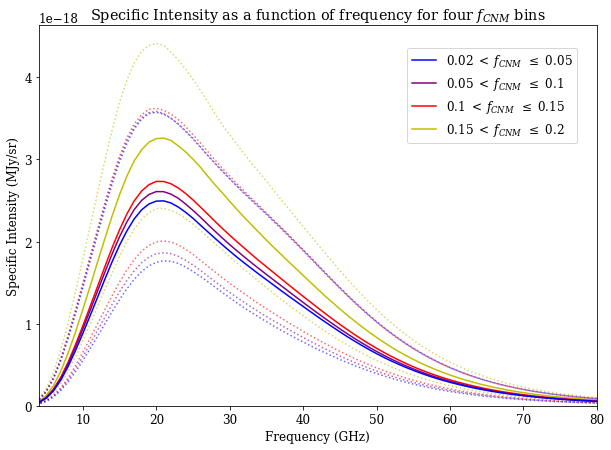

In [12]:
# Creates a map of I(nu) at each integer nu, binning
# pixels from these maps by f_CNM, and plotting
# median SEDs with standard deviations for each bin.

nu = np.linspace(1, 100, 100)

Im0, Im1, Im2, Im3 = (np.zeros(len(nu)) for i in range(4))
Is0, Is1, Is2, Is3 = (np.zeros(len(nu)) for i in range(4)) 
Ip0, Ip1, Ip2, Ip3 = (np.zeros((len(nu), 2)) for i in range(4))

low0, low1, low2, low3 = 0.02, 0.05, 0.10, 0.15
high0, high1, high2, high3 = 0.05, 0.10, 0.15, 0.20

I_normto = I_therm(Ad, Bd, Td, 545)

for i, freq in enumerate(nu):                               
    I_nu = I(a1, a2, nup1, nu_sd, f, freq)                        
    I_normalize = I_nu/N_HI

    Im0[i] = np.median(I_normalize[(fCNM > low0) & (fCNM <= high0)])
    Im1[i] = np.median(I_normalize[(fCNM > low1) & (fCNM <= high1)])
    Im2[i] = np.median(I_normalize[(fCNM > low2) & (fCNM <= high2)])
    Im3[i] = np.median(I_normalize[(fCNM > low3) & (fCNM <= high3)])
    
    Ip0[i,:] = np.percentile(I_normalize[(fCNM > low0) & (fCNM <= high0)], (16, 84))
    Ip1[i,:] = np.percentile(I_normalize[(fCNM > low1) & (fCNM <= high1)], (16, 84))
    Ip2[i,:] = np.percentile(I_normalize[(fCNM > low2) & (fCNM <= high2)], (16, 84))
    Ip3[i,:] = np.percentile(I_normalize[(fCNM > low3) & (fCNM <= high3)], (16, 84))


binfig, binax = plt.subplots(figsize=(10,7))

med3 = plot_binper(nu, Im3, Ip3[:,0], Ip3[:,1], 'y', binax)
med2 = plot_binper(nu, Im2, Ip2[:,0], Ip2[:,1], 'red', binax)
med1 = plot_binper(nu, Im1, Ip1[:,0], Ip1[:,1], 'purple', binax)
med0 = plot_binper(nu, Im0, Ip0[:,0], Ip0[:,1], 'blue', binax)
csigma = Line2D([0], [0], color='k', linewidth=3, linestyle=':')

label0 = f"{low0} " + r'$<\:f_{CNM}\;\:\leq$' + f" {high0}"
label1 = f"{low1} " + r'$<\:f_{CNM}\;\:\leq$' + f" {high1}"
label2 = f"{low2} " + r'$<\:f_{CNM}\;\:\leq$' + f" {high2}"
label3 = f"{low3} " + r'$<\:f_{CNM}\;\:\leq$' + f" {high3}" 
lsigma = 'represents ' + r'$\:\pm\:1\:\sigma$'

#binax.set_xscale('log')
#binax.set_yscale('log')
binax.set_xlim(4,80)
binax.set_ylim(0,)
binax.set_title('Specific Intensity as a function of frequency for four ' + r'$f_{CNM}$' + ' bins')
binax.set_xlabel('Frequency (GHz)')
binax.set_ylabel('Specific Intensity (MJy/sr)')

plt.figlegend(handles=[med0, med1, med2, med3], labels=[label0, label1, label2, label3], 
              loc='upper right', bbox_to_anchor=(0.81, 0.81))

#binfig.savefig('SED_bins_nosig.png', dpi=300)

In [13]:
# Finds frequency at which we see the average I for each pixel
fCNM_short = fCNM[idx]

I_nustack = np.zeros((len(nu), len(a1)))
I_unnorm = np.zeros((len(nu), len(a1)))
for i, freq in enumerate(nu):
    I_nu = I(a1, a2, nup1, nu_sd, f, freq)
    I_unnorm[i,:] = I_nu
    
    I_normalize = I_nu/I_normto
    I_nustack[i,:] = I_normalize

nu_flat = np.reshape(nu, (100,1))
integrand = nu_flat*I_nustack

Integ1 = integrate.simps(integrand.T)
Integ2 = integrate.simps(I_nustack.T)
Integ3 = integrate.simps(I_unnorm.T)
nu_avg = Integ1/Integ2
integ = Integ3/N_HI

integ_short = integ[idx]
nuavg_short = nu_avg[idx]

nuavg_means, nuavg_edges, nuavg_num = stats.binned_statistic(fCNM_short, nuavg_short, statistic='median', bins=150, range=[0.02, .36])
integ_means, integ_edges, integ_num = stats.binned_statistic(fCNM_short, integ_short, statistic='median', bins=150, range=[0.02, .36])

#Finds I(nu)/I(545) for various values of nu

I_sdtd2 = I20/I_normto
I_sdtd3 = I30/I_normto
I_sdtd4 = I(a1,a2,nup1,nu_sd,f,40)/I_normto
I_sdtd5 = I(a1,a2,nup1,nu_sd,f,50)/I_normto

I_sdtdshort20 = I_sdtd2[idx]
I_sdtdshort30 = I_sdtd3[idx]
I_sdtdshort40 = I_sdtd4[idx]
I_sdtdshort50 = I_sdtd5[idx]

numbins = 150
sdtd3_meds, sdtd3_edges, sdtd3_num = stats.binned_statistic(fCNM_short, I_sdtdshort30, statistic='median', bins=numbins, range=[0.02, .36])
sdtd2_meds, sdtd2_edges, sdtd2_num = stats.binned_statistic(fCNM_short, I_sdtdshort20, statistic='median', bins=numbins, range=[0.02, .36])
sdtd4_meds, sdtd4_edges, sdtd4_num = stats.binned_statistic(fCNM_short, I_sdtdshort40, statistic='median', bins=numbins, range=[0.02, .36])
sdtd5_meds, sdtd5_edges, sdtd5_num = stats.binned_statistic(fCNM_short, I_sdtdshort50, statistic='median', bins=numbins, range=[0.02, .36])

/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


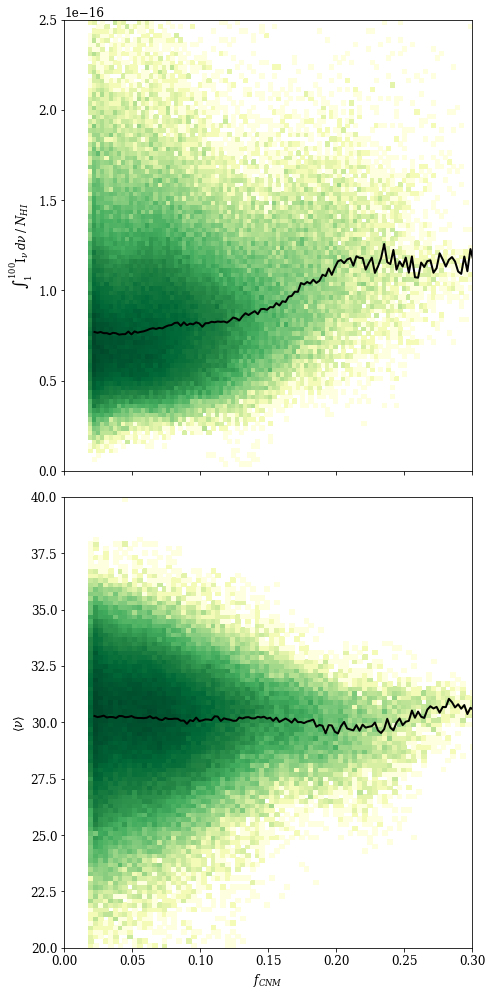

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(7,14), sharex=True)
#fig.text(0.518, 1, r'$\langle \nu \rangle\: vs.\: f_{CNM}$', ha='center')

ax[1].hist2d(fCNM_short, nuavg_short, bins=100,range=[[0, .36], [20, 40]], cmap='YlGn', norm=colors.LogNorm(.9))
ax[1].plot(nuavg_edges[1:], nuavg_means, 'k', lw=2)
ax[1].set_ylabel(r'$\langle \nu \rangle$')
ax[1].set_xlabel(r'$f_{CNM}$')

ax[0].hist2d(fCNM_short, integ_short, bins=100,range=[[0, .30], [0, 2.5e-16]], cmap='YlGn', norm=colors.LogNorm(.9))
ax[0].plot(integ_edges[1:], integ_means, 'k', lw=2)
ax[0].set_ylim(0,2.5e-16)
#ax[0].set_yscale('log')
ax[0].set_ylabel(r'$\int_1^{100} \mathrm{I}_{\nu}\:d\nu\:/\:N_{HI}$')

#ax[1].scatter(fCNM_short, nuavg_short, s=1, alpha=.3)
#ax[1].set_xlim(0, .36)
#ax[1].set_ylim(20, 40)
#ax[1].set_xlabel(r'$f_{CNM}$')

fig.tight_layout()

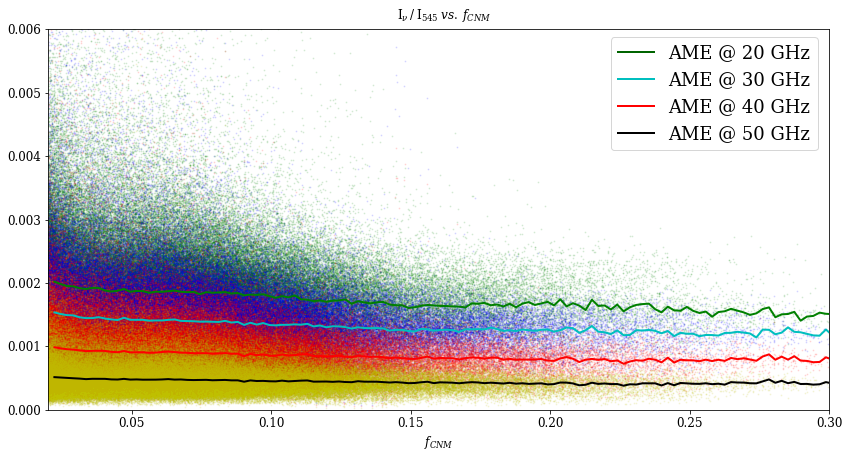

In [15]:
figirat, axirat = plt.subplots(figsize=(14,7))
figirat.text(0.518, .9, r'$\mathrm{I}_{\nu}\:/\:\mathrm{I}_{545} \; vs.\: f_{CNM}$', ha='center')

axirat.scatter(fCNM_short, I_sdtdshort20, s=1, alpha=.1, c='g')
axirat.scatter(fCNM_short, I_sdtdshort30, s=1, alpha=.1, c='b')
axirat.scatter(fCNM_short, I_sdtdshort40, s=1, alpha=.1, c='r')
axirat.scatter(fCNM_short, I_sdtdshort50, s=1, alpha=.1, c='y')
I30norm = axirat.plot(sdtd3_edges[1:], sdtd3_meds, 'c', lw=2)
I20norm = axirat.plot(sdtd2_edges[1:], sdtd2_meds, 'g', lw=2)
I40norm = axirat.plot(sdtd4_edges[1:], sdtd4_meds, 'r', lw=2)
I50norm = axirat.plot(sdtd5_edges[1:], sdtd5_meds, 'k', lw=2)
axirat.set_xlim(0.02, .30)
axirat.set_ylim(0, .006)
axirat.set_xlabel(r'$f_{CNM}$')

green = Line2D([0], [0], color='#006400', linewidth=2)
blue = Line2D([0], [0], color='#00008B', linewidth=2)
cyan = Line2D([0], [0], color='c', linewidth=2)
red = Line2D([0], [0], color='r', linewidth=2)
black = Line2D([0], [0], color='k', linewidth=2)

plt.figlegend(handles=[green, cyan, red, black], labels=['AME @ 20 GHz', 'AME @ 30 GHz', 
                                                         'AME @ 40 GHz', 'AME @ 50 GHz'], 
              loc='upper right', bbox_to_anchor=(0.82, 0.853), prop={'size': 18})

fig.savefig('nu_avg.png', dpi=300)
figirat.savefig('Inu_I545.png', dpi=300)

In [30]:
from scipy.optimize import minimize
import emcee
import corner

In [42]:
def nuavg_bins(lo, hi):
    nuavgbin = nuavg_short[(fCNM_short > lo) & (fCNM_short <= hi)]
    Fbin = fCNM_short[(fCNM_short > lo) & (fCNM_short <= hi)]
    return nuavgbin, Fbin

def integ_bins(lo, hi):
    integbin = integ_short[(fCNM_short > lo) & (fCNM_short <= hi)]
    Fbin = fCNM_short[(fCNM_short > lo) & (fCNM_short <= hi)]
    return integbin, Fbin

nuavg_bin0, F_bin0 = nuavg_bins(0.02, 0.05)
nuavg_bin1, F_bin1 = nuavg_bins(0.05, 0.10)
nuavg_bin2, F_bin2 = nuavg_bins(0.10, 0.15)
nuavg_bin3, F_bin3 = nuavg_bins(0.15, 0.20)
nuavg_bin4, F_bin4 = nuavg_bins(0.20, 0.25)
nuavg_bin5, F_bin5 = nuavg_bins(0.25, 0.30)

def shorten(x,y):
    index = np.random.randint(len(y), size=200)
    y_shorter = y[index]
    x_shorter = x[index]
    return x_shorter, y_shorter

f_0, nuavg_0 = shorten(F_bin0, nuavg_bin0)
f_1, nuavg_1 = shorten(F_bin1, nuavg_bin1)
f_2, nuavg_2 = shorten(F_bin2, nuavg_bin2)
f_3, nuavg_3 = shorten(F_bin3, nuavg_bin3)
f_4, nuavg_4 = shorten(F_bin4, nuavg_bin4)
f_5, nuavg_5 = shorten(F_bin5, nuavg_bin5)

def stack(items):
    stack = []
    for i in items:
        stack = np.append(stack, i)
    return stack    

nuavg_samp = stack([nuavg_0, nuavg_1, nuavg_2, nuavg_3, nuavg_4, nuavg_5])
fCNM_samp = stack([f_0, f_1, f_2, f_3, f_4, f_5])

In [43]:
nuavg_samp.size

1200

## MCMC take 2

In [44]:
N = len(nuavg_samp)
y = np.reshape(nuavg_samp, (N,1))
x = np.vander(fCNM_samp, N=2)

sigma = 2

def log_like(params):
    a, b = params
    theta = np.asarray([[a], [b]]) # shape is 2x1
    
    # store the covariance matrix and its inverse
    temp = np.full(N, sigma)
    cov = np.diag(temp**2)
    
    # store y - X*theta
    err = y - x @ theta # shape is Nx1
    
    return -0.5 * (N*np.log(2*np.pi) + 2*N*np.log(sigma) + err.T @ cov @ err)
    
    # likelihood is same function as sampling process for D: likelihood principle
    #return np.sum(scipy.stats.norm.logpdf(D, loc=mean, scale=sigma))

def log_prior(params):
    a, b = params
    return np.log(np.power(1 + a**2, -3/2)) + np.log(1/sigma) # prior

def neg_log_posterior(params):
    return -(log_like(params) + log_prior(params))

def log_post(params):
    return log_like(params) + log_prior(params)

params = (-0.02, 30)
result = minimize(neg_log_posterior, params)
print(result)

params = result.x[0], result.x[1]
print("Params =", params)

      fun: 10295.223423255144
 hess_inv: array([[ 0.02998405, -0.00440663],
       [-0.00440663,  0.00085474]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 44
      nit: 5
     njev: 11
   status: 0
  success: True
        x: array([-0.96063156, 30.25642905])
Params = (-0.9606315638385239, 30.25642904844433)


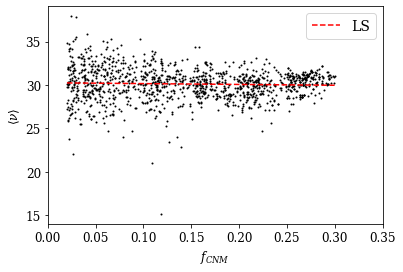

In [45]:
m_mle, b_mle = params[0], params[1]
x_ = np.linspace(0.02,np.amax(fCNM_samp),1000)
y_ = x_*m_mle + b_mle


plt.scatter(fCNM_samp, nuavg_samp, s=1, c="k")
plt.plot(x_, y_, "--r", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, .35)
plt.xlabel(r'$f_{CNM}$')
plt.ylabel(r'$\langle \nu \rangle$')
plt.show()

In [46]:
nwalkers, ndim = (30, 2)
params = (params[0], params[1])

pos = params + 1e-3 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post)
sampler.run_mcmc(pos, 5000, progress=True)

tau = sampler.get_autocorr_time()
print(tau)

100%|██████████| 5000/5000 [08:22<00:00,  9.95it/s]

[29.7571228  29.86737175]


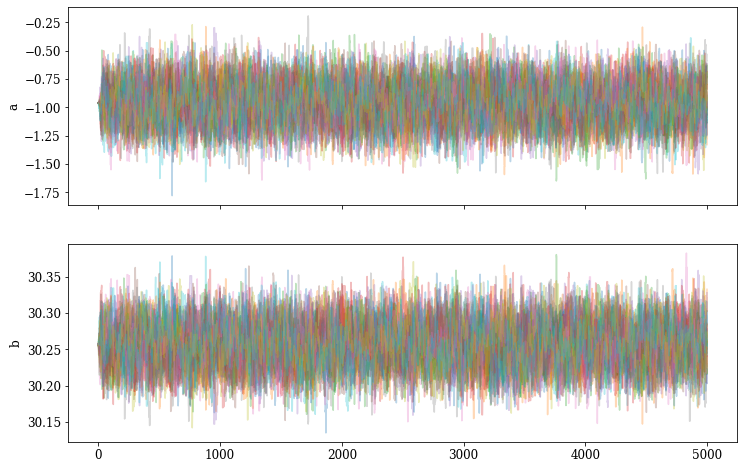

In [47]:
samples = sampler.get_chain()

fig, ax = plt.subplots(ndim, sharex=True, figsize=(12,8))
ylabels = ["a", "b", "log(sigma)"]
for i in range(ndim):
    ax[i].plot(samples[:,:,i], alpha=.3)
    ax[i].set_ylabel(ylabels[i])

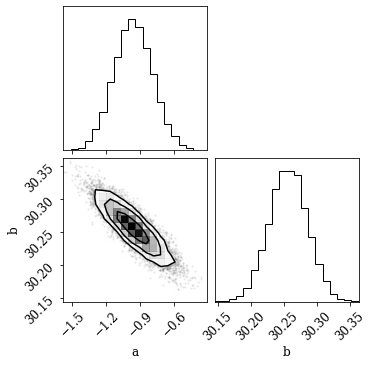

In [48]:
samples = sampler.get_chain(discard=100, thin=18, flat=True)
fig = corner.corner(samples, labels=ylabels)

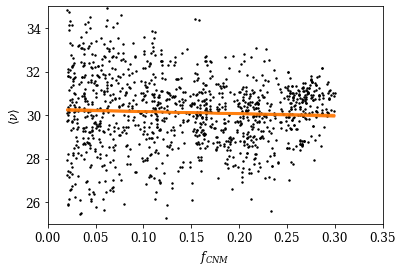

In [49]:
plt.scatter(fCNM_samp,nuavg_samp, s=2, c='k')
plt.xlim(0, .35)
plt.xlabel(r'$f_{CNM}$')
plt.ylabel(r'$\langle \nu \rangle$')

inds = np.random.randint(len(samples), size=100)
for ind in inds:
    sample = samples[ind]
    plt.plot(fCNM_samp, np.dot(np.vander(fCNM_samp, 2), sample[:2]), "C1", alpha=0.05)
    
plt.ylim(25,35)
plt.show()

## MCMC for total intensity

In [135]:
integ_bin0, F_bin0 = integ_bins(0.02, 0.05)
integ_bin1, F_bin1 = integ_bins(0.05, 0.10)
integ_bin2, F_bin2 = integ_bins(0.10, 0.15)
integ_bin3, F_bin3 = integ_bins(0.15, 0.20)

f_0, integ_0 = shorten(F_bin0, integ_bin0)
f_1, integ_1 = shorten(F_bin1, integ_bin1)
f_2, integ_2 = shorten(F_bin2, integ_bin2)
f_3, integ_3 = shorten(F_bin3, integ_bin3)

integ_samp = stack([integ_0, integ_1, integ_2, integ_3])*1e16
fCNM_samp = stack([f_0, f_1, f_2, f_3])

In [148]:
N = len(integ_samp)
y = np.reshape(integ_samp, (N,1))
x = np.vander(fCNM_samp, N=3, increasing=True)
params = (0.1, 0.1, .5)

sigma = .1

def log_like(params):
    a, b, c = params
    theta = np.asarray([[a], [b], [c]]) # shape is 2x1
    
    # store the covariance matrix and its inverse
    temp = np.full(N, sigma)
    cov = np.diag(temp**2)
    
    # store y - X*theta
    err = y - x @ theta # shape is Nx1
    
    return -0.5 * (N*np.log(2*np.pi) + 2*N*np.log(sigma) + err.T @ cov @ err)
    
    # likelihood is same function as sampling process for D: likelihood principle
    #return np.sum(scipy.stats.norm.logpdf(D, loc=mean, scale=sigma))

def log_prior(params):
    a, b, c = params
    return np.log(np.power(1 + a**2, -1/2)) + np.log(np.power(1 + b**2, -3/2)) + np.log(1/sigma) # prior

def neg_log_posterior(params):
    return -(log_like(params) + log_prior(params))

def log_post(params):
    return log_like(params) + log_prior(params)

result = minimize(neg_log_posterior, params)
print(result)

params = result.x[0], result.x[1], result.x[2]
print("Params =", params)

ValueError: not enough values to unpack (expected 3, got 1)

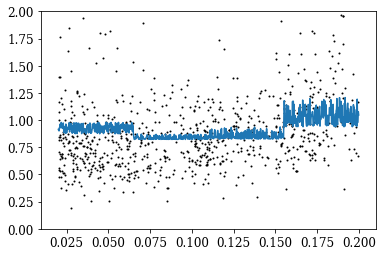

In [142]:
plt.scatter(fCNM_samp, integ_samp, s=1, c='k')
plt.plot(np.linspace(0.02,0.2,800), x @ params)
plt.ylim(0,2)
plt.show()